This notebook implements the hierarchical classification pipeline:

Stage 1 (Coarse): Anatomical region localization (brain, abdomen, chest)
Stage 2 (Fine): Region-specific pathology classification
Stage 3 (Subtype): Disease subtype identification (optional)


In [1]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt

from utils.hierarchical_model import HierarchicalClassificationModel
from utils.coarse_classifier import CoarseAnatomicalClassifier
from utils.fine_classifier import RegionSpecificPathologyNetwork
from utils.data_loader import get_medmnist_dataloaders, create_hierarchical_dataset
from utils.trainer import Trainer
from utils.metrics import compute_metrics, compute_hierarchical_metrics
from utils.visualization import (
    plot_training_history,
    plot_hierarchical_results,
    plot_confusion_matrix
)
from config import *

print(f"Device: {DEVICE}")
set_seed(42)

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Platform: NVIDIA CUDA
Device: cuda


In [2]:
# Load OrganMNIST3D dataset
train_loader, val_loader, test_loader, num_classes = get_medmnist_dataloaders(
    dataset_name='organ',
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print(f"Total organ classes: {num_classes}")
print(f"Training samples: {len(train_loader.dataset)}")

# Create organ-to-region mapping
ORGAN_TO_REGION_IDX = {
    'abdomen': 0,
    'chest': 1,
    
}

REGION_IDX_TO_NAME = {v: k for k, v in ORGAN_TO_REGION_IDX.items()}

# Map organ classes to region indices
organ_to_region_map = {}
for organ_idx, organ_name in ORGAN_CLASSES.items():
    region_name = ORGAN_TO_REGION[organ_name]
    region_idx = ORGAN_TO_REGION_IDX[region_name]
    organ_to_region_map[organ_idx] = region_idx

print("\nOrgan to Region mapping:")
for organ_idx, organ_name in ORGAN_CLASSES.items():
    region_idx = organ_to_region_map[organ_idx]
    region_name = REGION_IDX_TO_NAME[region_idx]
    print(f"  {organ_name:15s} -> {region_name}")

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Total organ classes: 11
Training samples: 971

Organ to Region mapping:
  bladder         -> abdomen
  femur-left      -> abdomen
  femur-right     -> abdomen
  heart           -> chest
  kidney-left     -> abdomen
  kidney-right    -> abdomen
  liver           -> abdomen
  lung-left       -> chest
  lung-right      -> chest
  pancreas        -> abdomen
  spleen          -> abdomen


In [3]:
print("="*60)
print("STAGE 1: Coarse Anatomical Region Classification")
print("="*60)

# Create coarse classifier with new architecture options
from utils.cnn_3d_models import get_3d_model

num_regions = len(ORGAN_TO_REGION_IDX)
architecture = MODEL_CONFIG['coarse_architecture']  # Use coarse-specific architecture

# Create coarse classifier
coarse_model = CoarseAnatomicalClassifier(
    architecture=architecture,
    num_regions=num_regions,
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    region_names=REGION_IDX_TO_NAME
).to(DEVICE)

print(f"\n Using {architecture.upper().replace('_', '-')} for Stage 1 (Coarse)")
print(f"Number of anatomical regions: {num_regions}")
print(f"Regions: {list(ORGAN_TO_REGION_IDX.keys())}")
print(f"Region index mapping: {REGION_IDX_TO_NAME}")

# Count parameters
coarse_params = sum(p.numel() for p in coarse_model.parameters())
print(f"Model parameters: {coarse_params:,}")
print(f"\n To change architecture, edit MODEL_CONFIG['coarse_architecture'] in config.py")

STAGE 1: Coarse Anatomical Region Classification

 Using RESNET18-3D for Stage 1 (Coarse)
Number of anatomical regions: 2
Regions: ['abdomen', 'chest']
Region index mapping: {0: 'abdomen', 1: 'chest'}
Model parameters: 33,161,026

 To change architecture, edit MODEL_CONFIG['coarse_architecture'] in config.py


In [4]:
# Custom data loader that converts organ labels to region labels
class RegionDataLoader:
    def __init__(self, data_loader, organ_to_region_map):
        self.data_loader = data_loader
        self.organ_to_region_map = organ_to_region_map
    
    def __iter__(self):
        for images, organ_labels in self.data_loader:
            # Convert organ labels to region labels
            # Flatten to 1D to handle both single and batch cases
            organ_labels_flat = organ_labels.view(-1)
            region_labels = torch.tensor([
                self.organ_to_region_map[label.item()]
                for label in organ_labels_flat
            ]).unsqueeze(-1)
            yield images, region_labels
    
    def __len__(self):
        return len(self.data_loader)
    
    @property
    def dataset(self):
        return self.data_loader.dataset

# Wrap data loaders
coarse_train_loader = RegionDataLoader(train_loader, organ_to_region_map)
coarse_val_loader = RegionDataLoader(val_loader, organ_to_region_map)
coarse_test_loader = RegionDataLoader(test_loader, organ_to_region_map)

print("Region-labeled data loaders created")

Region-labeled data loaders created


In [5]:
# Setup training for Stage 1

if torch.cuda.is_available(): torch.cuda.empty_cache()  # Clear GPU cache

coarse_criterion = nn.CrossEntropyLoss()
coarse_optimizer = optim.Adam(
    coarse_model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)
coarse_scheduler = StepLR(
    coarse_optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

coarse_trainer = Trainer(
    model=coarse_model,
    train_loader=coarse_train_loader,
    val_loader=coarse_val_loader,
    criterion=coarse_criterion,
    optimizer=coarse_optimizer,
    device=DEVICE,
    scheduler=coarse_scheduler
)

# Train Stage 1
print("\nTraining Stage 1: Coarse Region Classifier...\n")
coarse_history = coarse_trainer.train(num_epochs=TRAINING_CONFIG['coarse_epochs'])

print("\nStage 1 Training Complete!")
print(f"Best validation accuracy: {max(coarse_history['val_acc']):.4f}")


Training Stage 1: Coarse Region Classifier...


Epoch 1/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 101.57it/s]


Train Loss: 0.4594, Train Acc: 0.8290
Val Loss: 0.1625, Val Acc: 0.9938
New best validation accuracy: 0.9938

Epoch 2/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 103.64it/s]


Train Loss: 0.2972, Train Acc: 0.8888
Val Loss: 0.0681, Val Acc: 0.9876

Epoch 3/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 108.42it/s]


Train Loss: 0.2078, Train Acc: 0.9238
Val Loss: 0.2263, Val Acc: 0.8944

Epoch 4/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 103.90it/s]


Train Loss: 0.1784, Train Acc: 0.9403
Val Loss: 0.0511, Val Acc: 0.9938

Epoch 5/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 107.05it/s]


Train Loss: 0.1419, Train Acc: 0.9454
Val Loss: 0.0740, Val Acc: 0.9876

Epoch 6/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 108.18it/s]


Train Loss: 0.1231, Train Acc: 0.9526
Val Loss: 0.0408, Val Acc: 0.9938

Epoch 7/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 101.60it/s]


Train Loss: 0.1500, Train Acc: 0.9382
Val Loss: 0.0661, Val Acc: 0.9876

Epoch 8/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 108.38it/s]


Train Loss: 0.1223, Train Acc: 0.9557
Val Loss: 0.0257, Val Acc: 0.9938

Epoch 9/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 103.05it/s]


Train Loss: 0.1301, Train Acc: 0.9598
Val Loss: 0.0480, Val Acc: 0.9938

Epoch 10/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 109.03it/s]


Train Loss: 0.0921, Train Acc: 0.9691
Val Loss: 0.0259, Val Acc: 0.9938

Epoch 11/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 107.82it/s]


Train Loss: 0.0551, Train Acc: 0.9753
Val Loss: 0.0333, Val Acc: 0.9876

Epoch 12/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 104.71it/s]


Train Loss: 0.0343, Train Acc: 0.9876
Val Loss: 0.0362, Val Acc: 0.9876

Epoch 13/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 108.84it/s]


Train Loss: 0.0898, Train Acc: 0.9650
Val Loss: 0.0444, Val Acc: 0.9938

Epoch 14/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 103.89it/s]


Train Loss: 0.0547, Train Acc: 0.9773
Val Loss: 0.0169, Val Acc: 0.9938

Epoch 15/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 105.43it/s]


Train Loss: 0.0463, Train Acc: 0.9846
Val Loss: 0.0241, Val Acc: 0.9876

Epoch 16/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 106.25it/s]


Train Loss: 0.0208, Train Acc: 0.9928
Val Loss: 0.0282, Val Acc: 0.9938

Epoch 17/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 109.00it/s]


Train Loss: 0.0415, Train Acc: 0.9876
Val Loss: 0.0499, Val Acc: 0.9876

Epoch 18/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 110.53it/s]


Train Loss: 0.0183, Train Acc: 0.9928
Val Loss: 0.0176, Val Acc: 0.9938

Epoch 19/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 109.21it/s]


Train Loss: 0.0551, Train Acc: 0.9763
Val Loss: 0.0319, Val Acc: 0.9876

Epoch 20/20


Validation: 100%|██████████| 21/21 [00:00<00:00, 108.48it/s]

Train Loss: 0.0453, Train Acc: 0.9825
Val Loss: 0.0171, Val Acc: 0.9938

Stage 1 Training Complete!
Best validation accuracy: 0.9938


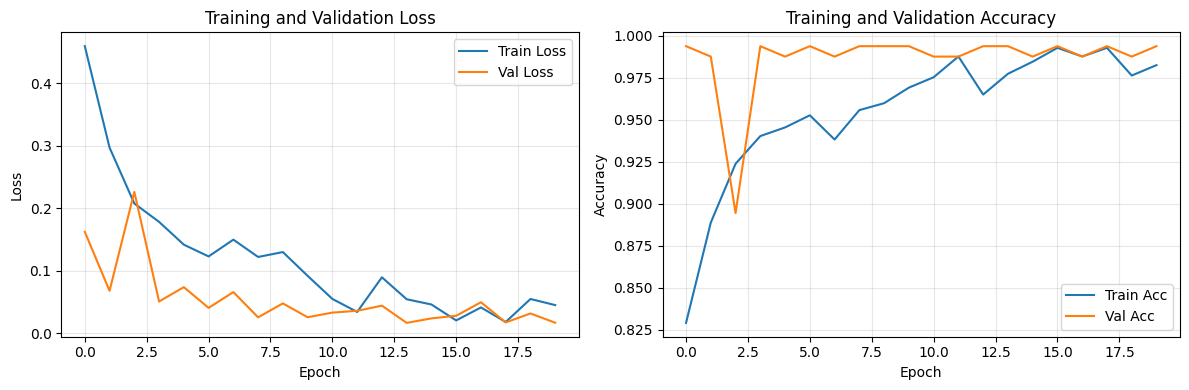

In [6]:
# Visualize Stage 1 results
plot_training_history(coarse_history, save_path='../figures/stage1_coarse_training.png')

Evaluating Stage 1 on test set...

Stage 1 Test Results:
  Accuracy:  0.9639
  Precision: 0.9635
  Recall:    0.9639
  F1-Score:  0.9637


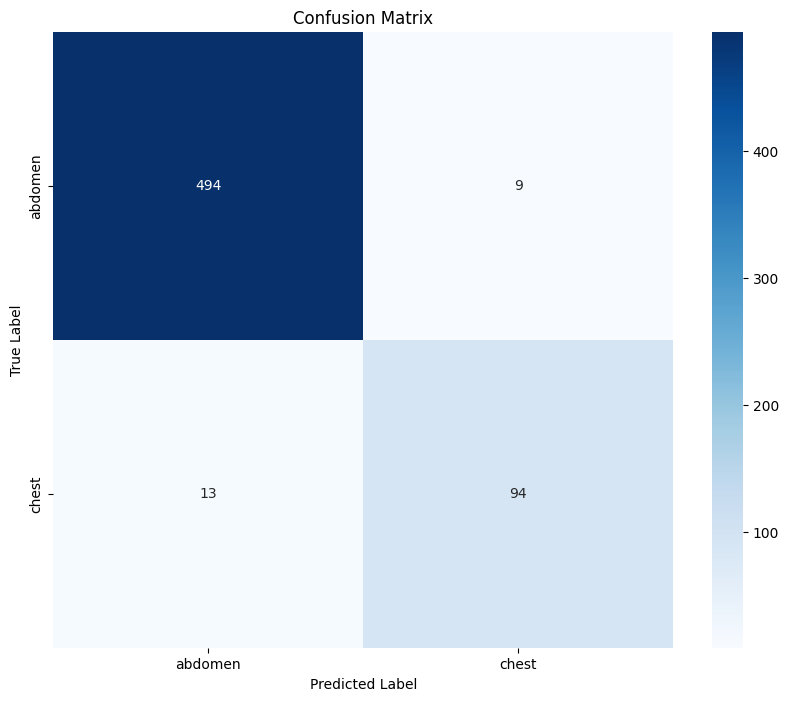

In [7]:
# Evaluate Stage 1 on test set
from utils.metrics import evaluate_model

print("Evaluating Stage 1 on test set...\n")
coarse_test_metrics, coarse_preds, coarse_labels = evaluate_model(
    coarse_model, coarse_test_loader, DEVICE
)

print("Stage 1 Test Results:")
print(f"  Accuracy:  {coarse_test_metrics['accuracy']:.4f}")
print(f"  Precision: {coarse_test_metrics['precision']:.4f}")
print(f"  Recall:    {coarse_test_metrics['recall']:.4f}")
print(f"  F1-Score:  {coarse_test_metrics['f1_score']:.4f}")

# Plot confusion matrix
region_names = list(ORGAN_TO_REGION_IDX.keys())
plot_confusion_matrix(
    coarse_test_metrics['confusion_matrix'],
    class_names=region_names,
    save_path='../figures/stage1_confusion_matrix.png'
)

In [8]:
print("="*60)
print("STAGE 2: Fine Pathology Classification")
print("="*60)

# Create region-to-organs mapping
region_to_organs = {'abdomen': {}, 'chest': {}}
for organ_idx, organ_name in ORGAN_CLASSES.items():
    region_name = ORGAN_TO_REGION[organ_name]
    region_to_organs[region_name][organ_idx] = organ_name

print("\nOrgans per region:")
for region, organs in region_to_organs.items():
    print(f"  {region}: {len(organs)} organs - {list(organs.values())}")

# For Stage 2, we'll train ONE model per region that classifies organs within that region


STAGE 2: Fine Pathology Classification

Organs per region:
  abdomen: 8 organs - ['bladder', 'femur-left', 'femur-right', 'kidney-left', 'kidney-right', 'liver', 'pancreas', 'spleen']
  chest: 3 organs - ['heart', 'lung-left', 'lung-right']


In [9]:
# Create complete hierarchical model with new architectures
print("\n" + "="*60)
print("TRAINING FULL HIERARCHICAL MODEL")
print("="*60)

# Build region configs with actual organ counts
region_configs = {}
for region_name in ['abdomen', 'chest']:
    num_organs = len(region_to_organs[region_name])
    region_configs[region_name] = num_organs

print(f"\nRegion configurations: {region_configs}")

# Get architectures from config
coarse_arch = MODEL_CONFIG['coarse_architecture']
fine_arch = MODEL_CONFIG['fine_architecture']

print(f"\n Stage 1 (Coarse): {coarse_arch.upper().replace('_', '-')}")
print(f" Stage 2 (Fine): {fine_arch.upper().replace('_', '-')}")

# Create hierarchical model with custom architectures
hierarchical_model = HierarchicalClassificationModel(
    region_configs=region_configs,
    coarse_model_type=coarse_arch,
    fine_model_type=fine_arch,
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    organ_to_region_map=organ_to_region_map,
    num_total_organs=num_classes,
    region_idx_to_name=REGION_IDX_TO_NAME
).to(DEVICE)

# Load Stage 1 weights
hierarchical_model.coarse_classifier.model.load_state_dict(coarse_model.model.state_dict())
print("\n✓ Stage 1 weights loaded into hierarchical model")

# Verify the region mapping is correct
print(f"✓ Region mapping verified: {hierarchical_model.coarse_classifier.region_names}")

# Train Stage 2: Fine classifiers for each region
print("\n" + "="*60)
print("Training Stage 2: End-to-End Hierarchical Model")
print("="*60)

# Freeze Stage 1 (keep coarse classifier frozen)
for param in hierarchical_model.coarse_classifier.parameters():
    param.requires_grad = False

print("\n✓ Stage 1 frozen, training Stage 2 only")

# Setup training for the hierarchical model
hierarchical_criterion = nn.CrossEntropyLoss()
hierarchical_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, hierarchical_model.parameters()),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)

hierarchical_scheduler = StepLR(
    hierarchical_optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

hierarchical_trainer = Trainer(
    model=hierarchical_model,
    train_loader=train_loader,  # Original organ-labeled data
    val_loader=val_loader,
    criterion=hierarchical_criterion,
    optimizer=hierarchical_optimizer,
    device=DEVICE,
    scheduler=hierarchical_scheduler
)

print(f"\n Training hierarchical model for {TRAINING_CONFIG['fine_epochs']} epochs...")
print("Stage 1 routes to regions, Stage 2 classifies organs within regions\n")

hierarchical_history = hierarchical_trainer.train(num_epochs=TRAINING_CONFIG['fine_epochs'])

print("\n Stage 2 Training Complete!")
print(f"Best hierarchical validation accuracy: {max(hierarchical_history['val_acc']):.4f}")


TRAINING FULL HIERARCHICAL MODEL

Region configurations: {'abdomen': 8, 'chest': 3}

 Stage 1 (Coarse): RESNET18-3D
 Stage 2 (Fine): RESNET18-3D

✓ Stage 1 weights loaded into hierarchical model
✓ Region mapping verified: {0: 'abdomen', 1: 'chest'}

Training Stage 2: End-to-End Hierarchical Model

✓ Stage 1 frozen, training Stage 2 only

 Training hierarchical model for 30 epochs...
Stage 1 routes to regions, Stage 2 classifies organs within regions


Epoch 1/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.11it/s]


Train Loss: 8239043.3040, Train Acc: 0.1946
Val Loss: 6211181.8193, Val Acc: 0.1925
New best validation accuracy: 0.1925

Epoch 2/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 60.60it/s]


Train Loss: 5149332.2870, Train Acc: 0.3038
Val Loss: 6211181.8429, Val Acc: 0.3665
New best validation accuracy: 0.3665

Epoch 3/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.56it/s]


Train Loss: 6179198.1810, Train Acc: 0.3738
Val Loss: 6211181.2595, Val Acc: 0.4783
New best validation accuracy: 0.4783

Epoch 4/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.56it/s]


Train Loss: 5149331.9645, Train Acc: 0.4820
Val Loss: 6211180.9539, Val Acc: 0.7267
New best validation accuracy: 0.7267

Epoch 5/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 64.68it/s]


Train Loss: 7209064.0287, Train Acc: 0.5118
Val Loss: 6211181.0473, Val Acc: 0.6149

Epoch 6/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 61.93it/s]


Train Loss: 6179197.7507, Train Acc: 0.6097
Val Loss: 6211181.1229, Val Acc: 0.5652

Epoch 7/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.91it/s]


Train Loss: 2059733.1924, Train Acc: 0.6251
Val Loss: 6211180.8675, Val Acc: 0.7453
New best validation accuracy: 0.7453

Epoch 8/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.98it/s]


Train Loss: 4119465.2558, Train Acc: 0.6880
Val Loss: 6211180.7419, Val Acc: 0.7516
New best validation accuracy: 0.7516

Epoch 9/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 63.63it/s]


Train Loss: 4119465.4483, Train Acc: 0.7034
Val Loss: 6211180.8997, Val Acc: 0.6584

Epoch 10/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.80it/s]


Train Loss: 7209063.5917, Train Acc: 0.6715
Val Loss: 6211180.6298, Val Acc: 0.7640
New best validation accuracy: 0.7640

Epoch 11/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 64.41it/s]


Train Loss: 4119465.0070, Train Acc: 0.7971
Val Loss: 6211180.4542, Val Acc: 0.8882
New best validation accuracy: 0.8882

Epoch 12/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.59it/s]


Train Loss: 7209063.2463, Train Acc: 0.8435
Val Loss: 6211180.4223, Val Acc: 0.8944
New best validation accuracy: 0.8944

Epoch 13/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 63.57it/s]


Train Loss: 5149330.8933, Train Acc: 0.8908
Val Loss: 6211180.4479, Val Acc: 0.9130
New best validation accuracy: 0.9130

Epoch 14/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.05it/s]


Train Loss: 7209063.0832, Train Acc: 0.8970
Val Loss: 6211180.3651, Val Acc: 0.9255
New best validation accuracy: 0.9255

Epoch 15/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 64.17it/s]


Train Loss: 11328527.4867, Train Acc: 0.9176
Val Loss: 6211180.4085, Val Acc: 0.9255

Epoch 16/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.88it/s]


Train Loss: 6179196.9238, Train Acc: 0.9135
Val Loss: 6211180.4028, Val Acc: 0.9255

Epoch 17/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 60.72it/s]


Train Loss: 6179196.8759, Train Acc: 0.9269
Val Loss: 6211182.6161, Val Acc: 0.8199

Epoch 18/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 63.43it/s]


Train Loss: 8238929.1882, Train Acc: 0.9217
Val Loss: 6211180.4685, Val Acc: 0.9193

Epoch 19/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 63.26it/s]


Train Loss: 6179197.3752, Train Acc: 0.9361
Val Loss: 6211180.9896, Val Acc: 0.8820

Epoch 20/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 63.16it/s]


Train Loss: 3089598.5060, Train Acc: 0.9588
Val Loss: 6211180.7846, Val Acc: 0.8323

Epoch 21/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 65.60it/s]


Train Loss: 3089598.4143, Train Acc: 0.9763
Val Loss: 6211180.4379, Val Acc: 0.9317
New best validation accuracy: 0.9317

Epoch 22/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 61.79it/s]


Train Loss: 5149330.6142, Train Acc: 0.9835
Val Loss: 6211180.4399, Val Acc: 0.9441
New best validation accuracy: 0.9441

Epoch 23/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.60it/s]


Train Loss: 7209062.8524, Train Acc: 0.9846
Val Loss: 6211180.4869, Val Acc: 0.9503
New best validation accuracy: 0.9503

Epoch 24/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 63.81it/s]


Train Loss: 5149330.5655, Train Acc: 0.9846
Val Loss: 6211180.4636, Val Acc: 0.9503

Epoch 25/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.29it/s]


Train Loss: 7209062.6391, Train Acc: 0.9866
Val Loss: 6211180.7614, Val Acc: 0.9255

Epoch 26/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 62.15it/s]


Train Loss: 8238931.5222, Train Acc: 0.9598
Val Loss: 6211180.4406, Val Acc: 0.9255

Epoch 27/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 64.01it/s]


Train Loss: 5149330.4894, Train Acc: 0.9722
Val Loss: 6211180.4691, Val Acc: 0.9379

Epoch 28/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 63.52it/s]


Train Loss: 6179196.0453, Train Acc: 0.9804
Val Loss: 6211183.5160, Val Acc: 0.9006

Epoch 29/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 64.82it/s]


Train Loss: 5149382.7574, Train Acc: 0.9464
Val Loss: 6211180.8205, Val Acc: 0.8012

Epoch 30/30


Validation: 100%|██████████| 21/21 [00:00<00:00, 64.32it/s]

Train Loss: 3089598.4837, Train Acc: 0.9032
Val Loss: 6211180.9225, Val Acc: 0.7826

 Stage 2 Training Complete!
Best hierarchical validation accuracy: 0.9503


EVALUATING FULL HIERARCHICAL MODEL

Evaluating on test set...

Full Hierarchical Model Test Results:
  Accuracy:  0.7082
  Precision: 0.6828
  Recall:    0.7082
  F1-Score:  0.6863


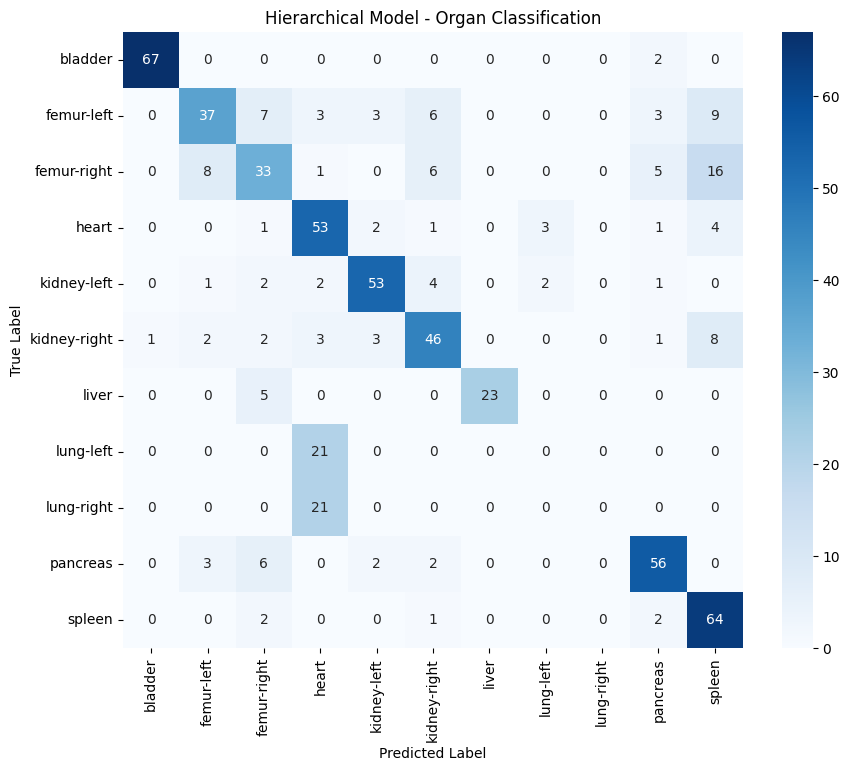


✓ Full hierarchical model evaluation complete


In [10]:
# Evaluate Full Hierarchical Model

print("="*60)
print("EVALUATING FULL HIERARCHICAL MODEL")
print("="*60)

hierarchical_model.eval()

# Evaluate on test set
print("\nEvaluating on test set...")
hierarchical_test_metrics, hierarchical_preds, hierarchical_labels = evaluate_model(
    hierarchical_model, test_loader, DEVICE
)

print("\nFull Hierarchical Model Test Results:")
print(f"  Accuracy:  {hierarchical_test_metrics['accuracy']:.4f}")
print(f"  Precision: {hierarchical_test_metrics['precision']:.4f}")
print(f"  Recall:    {hierarchical_test_metrics['recall']:.4f}")
print(f"  F1-Score:  {hierarchical_test_metrics['f1_score']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(
    hierarchical_test_metrics['confusion_matrix'],
    class_names=list(ORGAN_CLASSES.values()),
    save_path='../figures/hierarchical_confusion_matrix.png',
    title='Hierarchical Model - Organ Classification'
)

print("\n✓ Full hierarchical model evaluation complete")

In [11]:
## Hierarchical vs Stage 1 Comparison

print("="*60)
print("COMPARISON: Stage 1 Only vs Full Hierarchical")
print("="*60)

print("\nStage 1 (Region Classification Only):")
print(f"  Number of classes: {len(ORGAN_TO_REGION_IDX)}")
print(f"  Test Accuracy: {coarse_test_metrics['accuracy']:.4f}")

print("\nFull Hierarchical (Stage 1 → Stage 2):")
print(f"  Number of classes: {num_classes}")
print(f"  Test Accuracy: {hierarchical_test_metrics['accuracy']:.4f}")

print("\n Key Insight:")
print("The hierarchical model performs end-to-end organ classification")
print("by first localizing the region (Stage 1), then classifying the")
print("specific organ within that region (Stage 2).")

COMPARISON: Stage 1 Only vs Full Hierarchical

Stage 1 (Region Classification Only):
  Number of classes: 2
  Test Accuracy: 0.9639

Full Hierarchical (Stage 1 → Stage 2):
  Number of classes: 11
  Test Accuracy: 0.7082

 Key Insight:
The hierarchical model performs end-to-end organ classification
by first localizing the region (Stage 1), then classifying the
specific organ within that region (Stage 2).


In [12]:
# Demo: Hierarchical prediction on test samples
hierarchical_model.eval()

# Get a batch of test images
test_images, test_organ_labels = next(iter(test_loader))
test_images = test_images.to(DEVICE, dtype=torch.float32)
if test_images.max() > 1:
    test_images = test_images / 255.0

with torch.no_grad():
    # Stage 1: Predict anatomical region
    region_idx, region_names, region_conf = hierarchical_model.coarse_classifier.predict_region(
        test_images
    )

print("Hierarchical Prediction Example:")
print("="*60)
for i in range(min(5, len(test_images))):
    true_organ = ORGAN_CLASSES[test_organ_labels[i].item()]
    pred_region = region_names[i]
    region_confidence = region_conf[i].item()
    true_region = ORGAN_TO_REGION[true_organ]
    
    print(f"\nSample {i+1}:")
    print(f"  True organ: {true_organ} (region: {true_region})")
    print(f"  Predicted region: {pred_region} (confidence: {region_confidence:.3f})")
    print(f"  Region correct: {pred_region == true_region}")

Hierarchical Prediction Example:

Sample 1:
  True organ: spleen (region: abdomen)
  Predicted region: abdomen (confidence: 1.000)
  Region correct: True

Sample 2:
  True organ: femur-right (region: abdomen)
  Predicted region: abdomen (confidence: 0.998)
  Region correct: True

Sample 3:
  True organ: heart (region: chest)
  Predicted region: chest (confidence: 0.956)
  Region correct: True

Sample 4:
  True organ: kidney-left (region: abdomen)
  Predicted region: abdomen (confidence: 0.975)
  Region correct: True

Sample 5:
  True organ: pancreas (region: abdomen)
  Predicted region: abdomen (confidence: 1.000)
  Region correct: True


In [13]:
# Save FULL hierarchical model
import os
os.makedirs('../models', exist_ok=True)

torch.save({
    'coarse_model_state': coarse_model.state_dict(),
    'hierarchical_model_state': hierarchical_model.state_dict(),
    'coarse_history': coarse_history,
    'hierarchical_history': hierarchical_history,
    'coarse_test_metrics': coarse_test_metrics,
    'hierarchical_test_metrics': hierarchical_test_metrics,
    'region_configs': region_configs,
    'organ_to_region_map': organ_to_region_map,
    'region_to_organs': region_to_organs,
}, '../models/hierarchical_model.pth')

print("✓ FULL Hierarchical model saved to '../models/hierarchical_model.pth'")
print("\nSaved components:")
print("  - Stage 1 coarse classifier (region localization)")
print("  - Stage 2 fine classifiers (region-specific organ classification)")
print("  - Complete hierarchical pipeline")
print("  - Training histories and test metrics")

✓ FULL Hierarchical model saved to '../models/hierarchical_model.pth'

Saved components:
  - Stage 1 coarse classifier (region localization)
  - Stage 2 fine classifiers (region-specific organ classification)
  - Complete hierarchical pipeline
  - Training histories and test metrics


# K-Fold Cross-Validation with AUC Metrics

This section implements k-fold cross-validation for both Stage 1 (coarse region classification) and the full hierarchical model, with AUC (Area Under the ROC Curve) measurement.

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import copy

# Configuration for k-fold cross-validation
K_FOLDS = 5
KFOLD_EPOCHS_COARSE = 15  # Reduced epochs for faster k-fold
KFOLD_EPOCHS_FINE = 20

print(f"K-Fold Cross-Validation Configuration:")
print(f"  Number of folds: {K_FOLDS}")
print(f"  Epochs per fold (Stage 1): {KFOLD_EPOCHS_COARSE}")
print(f"  Epochs per fold (Hierarchical): {KFOLD_EPOCHS_FINE}")

K-Fold Cross-Validation Configuration:
  Number of folds: 5
  Epochs per fold (Stage 1): 15
  Epochs per fold (Hierarchical): 20


In [15]:
# Prepare full dataset for k-fold (combine train + val)
from torch.utils.data import ConcatDataset, Subset, DataLoader

# Combine train and val datasets
full_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset])

# Extract all labels for stratification
all_labels = []
for i in range(len(full_dataset)):
    _, label = full_dataset[i]
    all_labels.append(label.item())

all_labels = np.array(all_labels)

print(f"Total samples for k-fold: {len(full_dataset)}")
print(f"Label distribution: {np.bincount(all_labels)}")

Total samples for k-fold: 1132
Label distribution: [131 131 129 105 108 109  53  52  52 131 131]


In [16]:
def compute_auc_metrics(model, data_loader, device, num_classes, task_name="classification"):
    """
    Compute AUC metrics for multi-class classification.
    Returns both macro and weighted AUC scores.
    """
    model.eval()
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            
            labels = labels.view(-1)
            
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Binarize labels for multi-class AUC
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))
    
    # Compute AUC scores
    try:
        auc_macro = roc_auc_score(labels_binarized, all_probs, average='macro', multi_class='ovr')
        auc_weighted = roc_auc_score(labels_binarized, all_probs, average='weighted', multi_class='ovr')
    except ValueError as e:
        print(f"Warning: Could not compute AUC - {e}")
        auc_macro = 0.0
        auc_weighted = 0.0
    
    # Compute per-class AUC
    per_class_auc = []
    for i in range(num_classes):
        if len(np.unique(labels_binarized[:, i])) > 1:  # Check if class exists in this fold
            try:
                class_auc = roc_auc_score(labels_binarized[:, i], all_probs[:, i])
                per_class_auc.append(class_auc)
            except:
                per_class_auc.append(0.0)
        else:
            per_class_auc.append(0.0)
    
    return {
        'auc_macro': auc_macro,
        'auc_weighted': auc_weighted,
        'per_class_auc': per_class_auc,
        'all_labels': all_labels,
        'all_probs': all_probs
    }

print("✓ AUC computation function defined")

✓ AUC computation function defined


## K-Fold Cross-Validation: Stage 1 (Coarse Region Classification)

In [17]:
print("="*60)
print("K-FOLD CROSS-VALIDATION: STAGE 1 (COARSE)")
print("="*60)

# Convert organ labels to region labels for stratification
region_labels = np.array([organ_to_region_map[label] for label in all_labels])

# Initialize k-fold
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Store results for each fold
coarse_kfold_results = {
    'fold_accuracies': [],
    'fold_auc_macro': [],
    'fold_auc_weighted': [],
    'fold_histories': []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(region_labels)), region_labels)):
    print(f"\n{'='*60}")
    print(f"FOLD {fold + 1}/{K_FOLDS}")
    print(f"{'='*60}")
    
    # Create data loaders for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    fold_train_loader = DataLoader(
        train_subset,
        batch_size=DATA_CONFIG['batch_size'],
        shuffle=True,
        num_workers=DATA_CONFIG['num_workers']
    )
    fold_val_loader = DataLoader(
        val_subset,
        batch_size=DATA_CONFIG['batch_size'],
        shuffle=False,
        num_workers=DATA_CONFIG['num_workers']
    )
    
    # Wrap with region labels
    fold_train_region_loader = RegionDataLoader(fold_train_loader, organ_to_region_map)
    fold_val_region_loader = RegionDataLoader(fold_val_loader, organ_to_region_map)
    
    print(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
    
    # Create fresh model for this fold
    fold_coarse_model = CoarseAnatomicalClassifier(
        architecture=MODEL_CONFIG['coarse_architecture'],
        num_regions=num_regions,
        dropout_rate=MODEL_CONFIG['dropout_rate'],
        region_names=REGION_IDX_TO_NAME
    ).to(DEVICE)
    
    # Setup optimizer and scheduler
    fold_optimizer = optim.Adam(
        fold_coarse_model.parameters(),
        lr=TRAINING_CONFIG['learning_rate'],
        weight_decay=TRAINING_CONFIG['weight_decay']
    )
    fold_scheduler = StepLR(
        fold_optimizer,
        step_size=TRAINING_CONFIG['scheduler_step_size'],
        gamma=TRAINING_CONFIG['scheduler_gamma']
    )
    
    # Train
    fold_trainer = Trainer(
        model=fold_coarse_model,
        train_loader=fold_train_region_loader,
        val_loader=fold_val_region_loader,
        criterion=nn.CrossEntropyLoss(),
        optimizer=fold_optimizer,
        device=DEVICE,
        scheduler=fold_scheduler
    )
    
    if torch.cuda.is_available(): torch.cuda.empty_cache()  # Clear GPU cache
    fold_history = fold_trainer.train(num_epochs=KFOLD_EPOCHS_COARSE)
    
    # Evaluate on validation set
    val_metrics, _, _ = evaluate_model(fold_coarse_model, fold_val_region_loader, DEVICE)
    
    # Compute AUC
    auc_results = compute_auc_metrics(
        fold_coarse_model,
        fold_val_region_loader,
        DEVICE,
        num_regions,
        task_name="coarse"
    )
    
    # Store results
    coarse_kfold_results['fold_accuracies'].append(val_metrics['accuracy'])
    coarse_kfold_results['fold_auc_macro'].append(auc_results['auc_macro'])
    coarse_kfold_results['fold_auc_weighted'].append(auc_results['auc_weighted'])
    coarse_kfold_results['fold_histories'].append(fold_history)
    
    print(f"\nFold {fold + 1} Results:")
    print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"  AUC (macro): {auc_results['auc_macro']:.4f}")
    print(f"  AUC (weighted): {auc_results['auc_weighted']:.4f}")
    
    # Clean up
    del fold_coarse_model, fold_optimizer, fold_scheduler, fold_trainer
    if torch.cuda.is_available(): torch.cuda.empty_cache()  # Clear GPU cache

print(f"\n{'='*60}")
print("STAGE 1 K-FOLD RESULTS SUMMARY")
print(f"{'='*60}")
print(f"Accuracy: {np.mean(coarse_kfold_results['fold_accuracies']):.4f} ± {np.std(coarse_kfold_results['fold_accuracies']):.4f}")
print(f"AUC (macro): {np.mean(coarse_kfold_results['fold_auc_macro']):.4f} ± {np.std(coarse_kfold_results['fold_auc_macro']):.4f}")
print(f"AUC (weighted): {np.mean(coarse_kfold_results['fold_auc_weighted']):.4f} ± {np.std(coarse_kfold_results['fold_auc_weighted']):.4f}")

K-FOLD CROSS-VALIDATION: STAGE 1 (COARSE)

FOLD 1/5
Train samples: 905, Val samples: 227

Epoch 1/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 112.59it/s]


Train Loss: 0.4513, Train Acc: 0.8166
Val Loss: 0.2463, Val Acc: 0.9163
New best validation accuracy: 0.9163

Epoch 2/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 100.83it/s]


Train Loss: 0.3032, Train Acc: 0.8818
Val Loss: 0.2292, Val Acc: 0.8943

Epoch 3/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 106.03it/s]


Train Loss: 0.2133, Train Acc: 0.9215
Val Loss: 0.3888, Val Acc: 0.8150

Epoch 4/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 110.03it/s]


Train Loss: 0.1833, Train Acc: 0.9326
Val Loss: 0.0683, Val Acc: 0.9736
New best validation accuracy: 0.9736

Epoch 5/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 109.98it/s]


Train Loss: 0.1665, Train Acc: 0.9425
Val Loss: 0.0908, Val Acc: 0.9648

Epoch 6/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 106.93it/s]


Train Loss: 0.1486, Train Acc: 0.9580
Val Loss: 0.0643, Val Acc: 0.9780
New best validation accuracy: 0.9780

Epoch 7/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 102.73it/s]


Train Loss: 0.1174, Train Acc: 0.9635
Val Loss: 0.1936, Val Acc: 0.9383

Epoch 8/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 107.69it/s]


Train Loss: 0.1266, Train Acc: 0.9470
Val Loss: 0.0651, Val Acc: 0.9824
New best validation accuracy: 0.9824

Epoch 9/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 112.04it/s]


Train Loss: 0.1122, Train Acc: 0.9602
Val Loss: 0.1183, Val Acc: 0.9515

Epoch 10/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 111.03it/s]


Train Loss: 0.1054, Train Acc: 0.9646
Val Loss: 0.0561, Val Acc: 0.9736

Epoch 11/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 106.64it/s]


Train Loss: 0.0682, Train Acc: 0.9790
Val Loss: 0.0441, Val Acc: 0.9912
New best validation accuracy: 0.9912

Epoch 12/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 110.38it/s]


Train Loss: 0.0556, Train Acc: 0.9812
Val Loss: 0.0473, Val Acc: 0.9824

Epoch 13/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 109.60it/s]


Train Loss: 0.0315, Train Acc: 0.9923
Val Loss: 0.0556, Val Acc: 0.9824

Epoch 14/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 107.49it/s]


Train Loss: 0.0467, Train Acc: 0.9812
Val Loss: 0.0329, Val Acc: 0.9868

Epoch 15/15


Validation: 100%|██████████| 29/29 [00:00<00:00, 104.53it/s]

Train Loss: 0.0598, Train Acc: 0.9790
Val Loss: 0.0527, Val Acc: 0.9868


IndexError: index 1 is out of bounds for axis 1 with size 1

## K-Fold Cross-Validation: Full Hierarchical Model

In [ ]:
print("="*60)
print("K-FOLD CROSS-VALIDATION: HIERARCHICAL MODEL")
print("="*60)

# Initialize k-fold with organ labels
skf_organ = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

# Store results for each fold
hierarchical_kfold_results = {
    'fold_accuracies': [],
    'fold_auc_macro': [],
    'fold_auc_weighted': [],
    'fold_histories': []
}

for fold, (train_idx, val_idx) in enumerate(skf_organ.split(np.zeros(len(all_labels)), all_labels)):
    print(f"\n{'='*60}")
    print(f"FOLD {fold + 1}/{K_FOLDS}")
    print(f"{'='*60}")
    
    # Create data loaders for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    fold_train_loader = DataLoader(
        train_subset,
        batch_size=DATA_CONFIG['batch_size'],
        shuffle=True,
        num_workers=DATA_CONFIG['num_workers']
    )
    fold_val_loader = DataLoader(
        val_subset,
        batch_size=DATA_CONFIG['batch_size'],
        shuffle=False,
        num_workers=DATA_CONFIG['num_workers']
    )
    
    print(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
    
    # Step 1: Train coarse classifier
    print(f"\n Training Stage 1 (Coarse) for fold {fold + 1}...")
    
    fold_train_region_loader = RegionDataLoader(fold_train_loader, organ_to_region_map)
    fold_val_region_loader = RegionDataLoader(fold_val_loader, organ_to_region_map)
    
    fold_coarse_model = CoarseAnatomicalClassifier(
        architecture=MODEL_CONFIG['coarse_architecture'],
        num_regions=num_regions,
        dropout_rate=MODEL_CONFIG['dropout_rate'],
        region_names=REGION_IDX_TO_NAME
    ).to(DEVICE)
    
    fold_coarse_optimizer = optim.Adam(
        fold_coarse_model.parameters(),
        lr=TRAINING_CONFIG['learning_rate'],
        weight_decay=TRAINING_CONFIG['weight_decay']
    )
    fold_coarse_scheduler = StepLR(
        fold_coarse_optimizer,
        step_size=TRAINING_CONFIG['scheduler_step_size'],
        gamma=TRAINING_CONFIG['scheduler_gamma']
    )
    
    fold_coarse_trainer = Trainer(
        model=fold_coarse_model,
        train_loader=fold_train_region_loader,
        val_loader=fold_val_region_loader,
        criterion=nn.CrossEntropyLoss(),
        optimizer=fold_coarse_optimizer,
        device=DEVICE,
        scheduler=fold_coarse_scheduler
    )
    
    if torch.cuda.is_available(): torch.cuda.empty_cache()  # Clear GPU cache
    _ = fold_coarse_trainer.train(num_epochs=KFOLD_EPOCHS_COARSE)
    
    # Step 2: Create and train hierarchical model
    print(f"\n Training Stage 2 (Hierarchical) for fold {fold + 1}...")
    
    fold_hierarchical_model = HierarchicalClassificationModel(
        region_configs=region_configs,
        coarse_model_type=MODEL_CONFIG['coarse_architecture'],
        fine_model_type=MODEL_CONFIG['fine_architecture'],
        dropout_rate=MODEL_CONFIG['dropout_rate'],
        organ_to_region_map=organ_to_region_map,
        num_total_organs=num_classes,
        region_idx_to_name=REGION_IDX_TO_NAME
    ).to(DEVICE)
    
    # Load coarse weights
    fold_hierarchical_model.coarse_classifier.model.load_state_dict(
        fold_coarse_model.model.state_dict()
    )
    
    # Freeze Stage 1
    for param in fold_hierarchical_model.coarse_classifier.parameters():
        param.requires_grad = False
    
    # Train Stage 2
    fold_hierarchical_optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, fold_hierarchical_model.parameters()),
        lr=TRAINING_CONFIG['learning_rate'],
        weight_decay=TRAINING_CONFIG['weight_decay']
    )
    fold_hierarchical_scheduler = StepLR(
        fold_hierarchical_optimizer,
        step_size=TRAINING_CONFIG['scheduler_step_size'],
        gamma=TRAINING_CONFIG['scheduler_gamma']
    )
    
    fold_hierarchical_trainer = Trainer(
        model=fold_hierarchical_model,
        train_loader=fold_train_loader,
        val_loader=fold_val_loader,
        criterion=nn.CrossEntropyLoss(),
        optimizer=fold_hierarchical_optimizer,
        device=DEVICE,
        scheduler=fold_hierarchical_scheduler
    )
    
    if torch.cuda.is_available(): torch.cuda.empty_cache()  # Clear GPU cache
    fold_history = fold_hierarchical_trainer.train(num_epochs=KFOLD_EPOCHS_FINE)
    
    # Evaluate on validation set
    val_metrics, _, _ = evaluate_model(fold_hierarchical_model, fold_val_loader, DEVICE)
    
    # Compute AUC
    auc_results = compute_auc_metrics(
        fold_hierarchical_model,
        fold_val_loader,
        DEVICE,
        num_classes,
        task_name="hierarchical"
    )
    
    # Store results
    hierarchical_kfold_results['fold_accuracies'].append(val_metrics['accuracy'])
    hierarchical_kfold_results['fold_auc_macro'].append(auc_results['auc_macro'])
    hierarchical_kfold_results['fold_auc_weighted'].append(auc_results['auc_weighted'])
    hierarchical_kfold_results['fold_histories'].append(fold_history)
    
    print(f"\nFold {fold + 1} Hierarchical Results:")
    print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"  AUC (macro): {auc_results['auc_macro']:.4f}")
    print(f"  AUC (weighted): {auc_results['auc_weighted']:.4f}")
    
    # Clean up
    del fold_coarse_model, fold_hierarchical_model
    del fold_coarse_optimizer, fold_hierarchical_optimizer
    del fold_coarse_scheduler, fold_hierarchical_scheduler
    del fold_coarse_trainer, fold_hierarchical_trainer
    if torch.cuda.is_available(): torch.cuda.empty_cache()  # Clear GPU cache

print(f"\n{'='*60}")
print("HIERARCHICAL MODEL K-FOLD RESULTS SUMMARY")
print(f"{'='*60}")
print(f"Accuracy: {np.mean(hierarchical_kfold_results['fold_accuracies']):.4f} ± {np.std(hierarchical_kfold_results['fold_accuracies']):.4f}")
print(f"AUC (macro): {np.mean(hierarchical_kfold_results['fold_auc_macro']):.4f} ± {np.std(hierarchical_kfold_results['fold_auc_macro']):.4f}")
print(f"AUC (weighted): {np.mean(hierarchical_kfold_results['fold_auc_weighted']):.4f} ± {np.std(hierarchical_kfold_results['fold_auc_weighted']):.4f}")

## Visualize K-Fold Results

In [ ]:
# Plot k-fold results comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Accuracy across folds
axes[0].plot(range(1, K_FOLDS + 1), coarse_kfold_results['fold_accuracies'], 
             marker='o', label='Stage 1 (Coarse)', linewidth=2, markersize=8)
axes[0].plot(range(1, K_FOLDS + 1), hierarchical_kfold_results['fold_accuracies'], 
             marker='s', label='Hierarchical', linewidth=2, markersize=8)
axes[0].axhline(y=np.mean(coarse_kfold_results['fold_accuracies']), 
                color='blue', linestyle='--', alpha=0.5, label='Coarse Mean')
axes[0].axhline(y=np.mean(hierarchical_kfold_results['fold_accuracies']), 
                color='orange', linestyle='--', alpha=0.5, label='Hierarchical Mean')
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy Across K-Folds', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, K_FOLDS + 1))

# Plot 2: AUC (macro) across folds
axes[1].plot(range(1, K_FOLDS + 1), coarse_kfold_results['fold_auc_macro'], 
             marker='o', label='Stage 1 (Coarse)', linewidth=2, markersize=8)
axes[1].plot(range(1, K_FOLDS + 1), hierarchical_kfold_results['fold_auc_macro'], 
             marker='s', label='Hierarchical', linewidth=2, markersize=8)
axes[1].axhline(y=np.mean(coarse_kfold_results['fold_auc_macro']), 
                color='blue', linestyle='--', alpha=0.5, label='Coarse Mean')
axes[1].axhline(y=np.mean(hierarchical_kfold_results['fold_auc_macro']), 
                color='orange', linestyle='--', alpha=0.5, label='Hierarchical Mean')
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('AUC (Macro)', fontsize=12)
axes[1].set_title('AUC (Macro) Across K-Folds', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, K_FOLDS + 1))

# Plot 3: AUC (weighted) across folds
axes[2].plot(range(1, K_FOLDS + 1), coarse_kfold_results['fold_auc_weighted'], 
             marker='o', label='Stage 1 (Coarse)', linewidth=2, markersize=8)
axes[2].plot(range(1, K_FOLDS + 1), hierarchical_kfold_results['fold_auc_weighted'], 
             marker='s', label='Hierarchical', linewidth=2, markersize=8)
axes[2].axhline(y=np.mean(coarse_kfold_results['fold_auc_weighted']), 
                color='blue', linestyle='--', alpha=0.5, label='Coarse Mean')
axes[2].axhline(y=np.mean(hierarchical_kfold_results['fold_auc_weighted']), 
                color='orange', linestyle='--', alpha=0.5, label='Hierarchical Mean')
axes[2].set_xlabel('Fold', fontsize=12)
axes[2].set_ylabel('AUC (Weighted)', fontsize=12)
axes[2].set_title('AUC (Weighted) Across K-Folds', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(range(1, K_FOLDS + 1))

plt.tight_layout()
plt.savefig('../figures/kfold_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ K-fold comparison plot saved to '../figures/kfold_comparison.png'")

In [ ]:
# Summary statistics table
import pandas as pd

summary_data = {
    'Metric': ['Accuracy', 'AUC (Macro)', 'AUC (Weighted)'],
    'Stage 1 Mean': [
        f"{np.mean(coarse_kfold_results['fold_accuracies']):.4f}",
        f"{np.mean(coarse_kfold_results['fold_auc_macro']):.4f}",
        f"{np.mean(coarse_kfold_results['fold_auc_weighted']):.4f}"
    ],
    'Stage 1 Std': [
        f"{np.std(coarse_kfold_results['fold_accuracies']):.4f}",
        f"{np.std(coarse_kfold_results['fold_auc_macro']):.4f}",
        f"{np.std(coarse_kfold_results['fold_auc_weighted']):.4f}"
    ],
    'Hierarchical Mean': [
        f"{np.mean(hierarchical_kfold_results['fold_accuracies']):.4f}",
        f"{np.mean(hierarchical_kfold_results['fold_auc_macro']):.4f}",
        f"{np.mean(hierarchical_kfold_results['fold_auc_weighted']):.4f}"
    ],
    'Hierarchical Std': [
        f"{np.std(hierarchical_kfold_results['fold_accuracies']):.4f}",
        f"{np.std(hierarchical_kfold_results['fold_auc_macro']):.4f}",
        f"{np.std(hierarchical_kfold_results['fold_auc_weighted']):.4f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("K-FOLD CROSS-VALIDATION SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

In [ ]:
# Save k-fold results
kfold_save_path = '../models/kfold_results.pth'

torch.save({
    'coarse_kfold_results': coarse_kfold_results,
    'hierarchical_kfold_results': hierarchical_kfold_results,
    'k_folds': K_FOLDS,
    'kfold_epochs_coarse': KFOLD_EPOCHS_COARSE,
    'kfold_epochs_fine': KFOLD_EPOCHS_FINE,
    'summary_df': summary_df
}, kfold_save_path)

print(f"✓ K-fold results saved to '{kfold_save_path}'")